# Dimensionality Reduction and Generative Modelling

In [2]:
# Import theano
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

# numpy, plotting and pickle loading
import numpy as np
import time 
import matplotlib
import matplotlib.pyplot as plt
import six.moves.cPickle as pickle

# adam & plotting functions
from exercise_helper import gradient_updates_Adam
from exercise_helper import load_data,plot_2d_proj,plot_act_rec

theano.config.floatX = "float32"
rng_np = np.random.RandomState(23455)
srng = RandomStreams(seed=1234)

## Autoencoder

With an auto-encoder we try to learn a neural network which has the following structure:

`x                                  x*
x                                  x*
x       x1               x1*       x*
x       x1       l       x1*       x*
x ----> x1 ----> l ----> x1* ----> x*
x       x1               x1*       x*
x                                  x*
x                                  x*`

Assuming the column of $\mathbf{x}$ represents our input, we project that into an intermediate vector (vector $\mathbf{x}1$) followed by a lower-dimensional (2 dimensions in the above architecture) embedding vector. One way to think about this is data compression. 

If we try to compress the higher dimensional $\mathbf{x}$ vector into two dimensions, we should be able to de-compress the lower-dimensional embedding back into the original data. This is the motivation behind trying to **reconstruct** the data, where $\mathbf{x*}$ is the reconstructed vector.

Each projection, $\mathbf{x} \rightarrow \mathbf{x1} \rightarrow \mathbf{l} \rightarrow \mathbf{x1*} \rightarrow \mathbf{x*}$ is done using a non-linear transformation i.e. $\mathbf{x1} = activation(W_{x\_x1} \mathbf{x} + \mathbf{b})$ where $W_{x\_x1}$ and $\mathbf{b}$ are weights and biases for input layer to the first hidden layer connections. All the parameters are then learned by minimizing the difference between the original vector and reconstructed vector using standard backpropagation techniques.

After training the auto-encoder we see how well it performs by projecting the test-set into a lower (two) dimension space and plotting the result.

In [3]:
datasets = load_data('mnist.pkl.gz', train_size = 50000,binarize = "stochastic")
train_x, train_y = datasets[0]
valid_x, valid_y = datasets[1]
test_x, test_y = datasets[2]

***** Loading data *****


In [11]:
# implementing the autoencoder in theano
input = T.fmatrix("input") # symbolic float32 matrix, eventually will have (minibatch x 784)
learning_rate = T.fscalar("learning_rate") # float32 learning rate.
mbidxs = T.lvector("mbidxs") # minibath vector

# autoencoder layer dimensions
dims = [784, 500, 2, 500, 784]

# Glorot and Bengio initialization
uniform_lim = lambda n_in,n_out : (-np.sqrt(6.0/(n_in+n_out)), np.sqrt(6.0/(n_in+n_out))) 
W1 = theano.shared(rng_np.uniform(*uniform_lim(dims[0], dims[1]), size=dims[0:2]), borrow=True, name="W1") # n_in = 784, n_out = 300
W2 = theano.shared(rng_np.uniform(*uniform_lim(dims[1], dims[2]), size=dims[1:3]), borrow=True, name="W2") # n_in = 300, n_out = 2
W3 = theano.shared(rng_np.uniform(*uniform_lim(dims[2], dims[3]), size=dims[2:4]), borrow=True, name="W3") # n_in = 2, n_out = 300
W4 = theano.shared(rng_np.uniform(*uniform_lim(dims[3], dims[4]), size=dims[3:5]), borrow=True, name="W4") # n_in = 300, n_out = 784

# biases are all initialized to zeros
b1 = theano.shared(np.zeros((dims[1],)), borrow=True, name="b1")
b2 = theano.shared(np.zeros((dims[2],)), borrow=True, name="b2")
b3 = theano.shared(np.zeros((dims[3],)), borrow=True, name="b3")
b4 = theano.shared(np.zeros((dims[4],)), borrow=True, name="b4")

params = [W1,W2,W3,W4,b1,b2,b3,b4]
sigmoid = T.nnet.sigmoid
tanh = T.tanh

# forward-pass compuations
_input  = srng.binomial(n=1, p=0.95, size=input.shape) # add some random noise at the input layer
x1     = tanh(T.dot(input*_input, W1) + b1)
l      = T.dot(x1, W2) + b2
x1_rec = tanh(T.dot(l, W3) + b3)
x_rec  = sigmoid(T.dot(x1_rec, W4) + b4)

# cross entropy cost
cost = -T.mean(input * T.log(x_rec) + (1-input) * T.log(1-x_rec)) 

# Adam optimization
updates = gradient_updates_Adam(cost,params,learning_rate)

# takes an input and returns its reconstruction_error, reconstruction and lower dimensional representation.
autoencoder_train = theano.function(
        inputs = [mbidxs, learning_rate], 
        outputs = [cost, x_rec, l],
        updates = updates,
        givens = {
            input : train_x[mbidxs,:],
        }) 

# returns reconstructions and lower dimensional representation, no training happens here
autoencoder_predict = theano.function(
        inputs = [input],
        outputs = [cost, x_rec, l]
    ) 

In [6]:
mb_size = 50 # minibatch size
epochs = 10
lrate = 0.001
train_errors = []
valid_errors = []
train_start_time = time.time()

train_size = len(train_y.eval()) # number of training examples 
training_idxs = np.arange(train_size)

print("***** training started  *****")
for epoch in range(epochs):
    
    rng_np.shuffle(training_idxs) # randomize training idxs, randomizes in-place
    try:    
        t_minib_errors = []
        start_time = time.time()
        
        for batch_startidx in range(0, train_size, mb_size):
            mini_batch = training_idxs[batch_startidx:batch_startidx+mb_size]
            
            ## MAIN TRAINING
            rec_error, rec, low_dim = autoencoder_train(
                    mbidxs = np.asarray(mini_batch).astype(np.int32),
                    learning_rate=lrate)
            t_minib_errors.append(rec_error)

        valid_rec_error, valid_rec, low_dim = autoencoder_predict(input = valid_x.get_value())
        train_errors.append(np.mean(t_minib_errors))
        valid_errors.append(np.mean(valid_rec_error))
        print("epoch ={:>3d} -- train_error = {:>6.4f} -- valid_error = {:>6.4f} -- time = {:>5.3f}".format(epoch, train_errors[-1], valid_errors[-1], time.time()-start_time))    
        
    except KeyboardInterrupt as e:
        print("***** stopping *****")
        break


***** training started  *****
epoch =  0 -- train_error = 0.2447 -- valid_error = 0.2218 -- time = 37.212
***** stopping *****


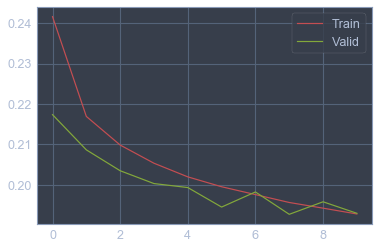

In [9]:
plt.plot(range(len(train_errors)), train_errors, "r", label="Train")
plt.plot(range(len(valid_errors)), valid_errors, "g", label="Valid")
plt.legend()
plt.show()

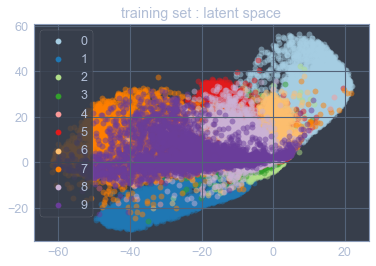

In [11]:
_, _, train_x_proj = autoencoder_predict(train_x.get_value())
plot_2d_proj(train_x_proj, train_y.eval(),"training set : latent space")

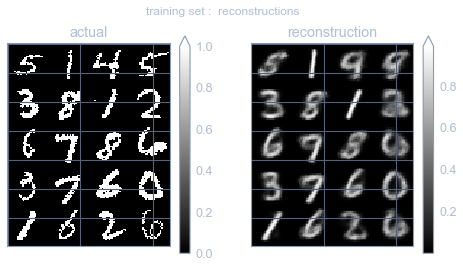

In [12]:
actual = train_x.get_value()[:20,:]
_,recons,_ = autoencoder_predict(actual)

plot_act_rec(actual,recons,"training set :  reconstructions")

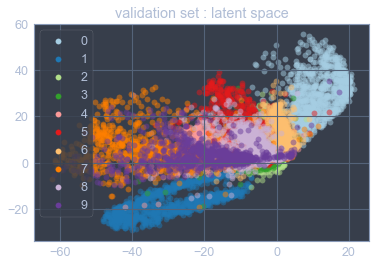

In [13]:
_, _, valid_x_proj = autoencoder_predict(valid_x.get_value())
plot_2d_proj(valid_x_proj, valid_y.eval(),"validation set : latent space")

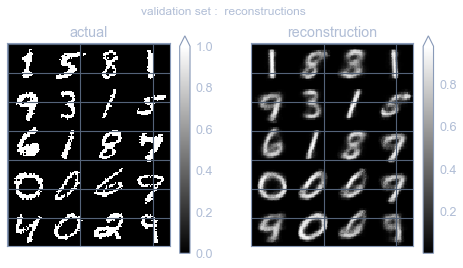

In [14]:
actual = valid_x.get_value()[:20,:]
_,recons,_ = autoencoder_predict(actual)
plot_act_rec(actual,recons,"validation set :  reconstructions")

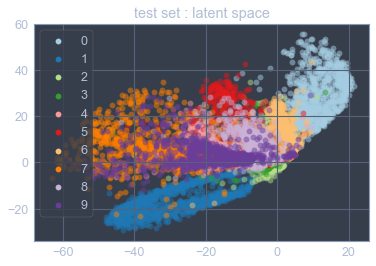

In [15]:
_, _, test_x_proj = autoencoder_predict(test_x.get_value())
plot_2d_proj(test_x_proj, test_y.eval(),"test set : latent space")

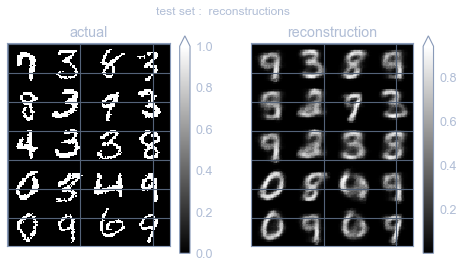

In [16]:
actual = test_x.get_value()[:20,:]
_,recons,_ = autoencoder_predict(actual)
plot_act_rec(actual,recons,"test set :  reconstructions")

** Pre-trained model**

Running 20 epochs with the above setting is not enough for training autoencoders. Now, we load weights for a model which was trained on all 50k MNIST training observations for 500 epochs with mini-batch size 500 (learning_rate = 0.0005). We can see that the latent space looks well separated and reconstructions are better now.

In [17]:
f = open('pretrained/autoencoder.save', 'rb')
param_dict = pickle.load(f)
f.close()

In [18]:
input = T.fmatrix("input") # symbolic float32 matrix, eventually will have (minibatch x 784)
dims = [784, 500, 2, 500, 784]

# load pre-trained values
W1 = theano.shared(param_dict['W1'], borrow=True, name="W1") # n_in = 784, n_out = 300
W2 = theano.shared(param_dict['W2'], borrow=True, name="W2") # n_in = 300, n_out = 2
W3 = theano.shared(param_dict['W3'], borrow=True, name="W3") # n_in = 2, n_out = 300
W4 = theano.shared(param_dict['W4'], borrow=True, name="W4") # n_in = 300, n_out = 784
b1 = theano.shared(param_dict['b1'], borrow=True, name="b1")
b2 = theano.shared(param_dict['b2'], borrow=True, name="b2")
b3 = theano.shared(param_dict['b3'], borrow=True, name="b3")
b4 = theano.shared(param_dict['b4'], borrow=True, name="b4")

params = [W1,W2,W3,W4,b1,b2,b3,b4]

sigmoid = T.nnet.sigmoid
tanh = T.tanh

# forward-pass computations
x1     = tanh(T.dot(input, W1) + b1)
l      = T.dot(x1, W2) + b2
x1_rec = tanh(T.dot(l, W3) + b3)
x_rec  = sigmoid(T.dot(x1_rec, W4) + b4)

# a predict function to return reconstructions
autoencoder_predict = theano.function(
        inputs = [input],
        outputs = [x_rec, l]
    )

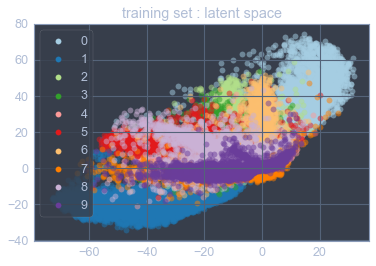

In [19]:
_, train_x_proj = autoencoder_predict(train_x.get_value())
plot_2d_proj(train_x_proj, train_y.eval(),"training set : latent space")

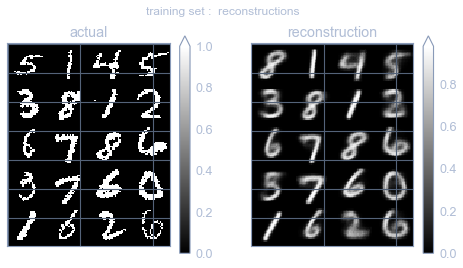

In [20]:
actual = train_x.get_value()[:20,:]
recons,_ = autoencoder_predict(actual)

plot_act_rec(actual,recons,"training set :  reconstructions")

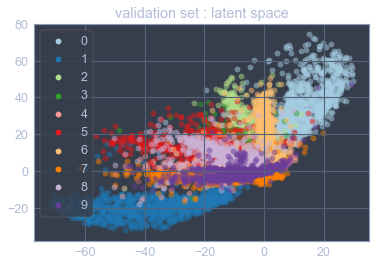

In [21]:
 _, valid_x_proj = autoencoder_predict(valid_x.get_value())
plot_2d_proj(valid_x_proj, valid_y.eval(),"validation set : latent space")

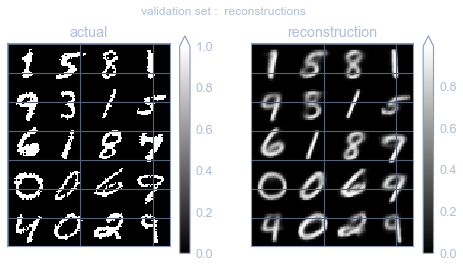

In [22]:
actual = valid_x.get_value()[:20,:]
recons,_ = autoencoder_predict(actual)
plot_act_rec(actual,recons,"validation set :  reconstructions")

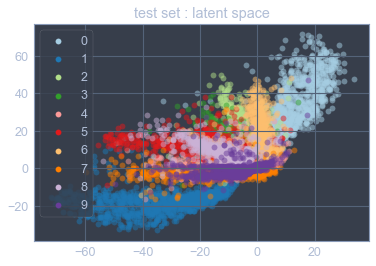

In [23]:
_, test_x_proj = autoencoder_predict(test_x.get_value())
plot_2d_proj(test_x_proj, test_y.eval(),"test set : latent space")

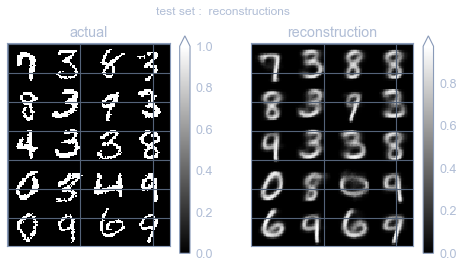

In [24]:
actual = test_x.get_value()[:20,:]
recons,_ = autoencoder_predict(actual)
plot_act_rec(actual,recons,"test set :  reconstructions")